In [135]:
import numpy as np
import heapq
import matplotlib.pyplot as plt
import matplotlib.patches
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D

from itertools import combinations, product
from math import pi, cos, sin, inf

%matplotlib inline

In [136]:
def create_triangle(xy, theta, r=0.1, color='b'):
    theta = theta - pi/2
    tri = matplotlib.patches.RegularPolygon(
        xy=xy, 
        numVertices=3, 
        radius=r, 
        orientation=theta,
        color=color,
    )
    return tri

In [137]:
def side_of_line(pa, pb, p):
    '''Returns -1 if p is in left half-plane determined 
       by points pa and pb, +1 if in right half-plane'''
    lhs = (p[1] - pa[1]) * (pb[0] - pa[0])
    rhs = (pb[1] - pa[1]) * (p[0] - pa[0])
    return np.sign(rhs - lhs)

In [138]:
def exists_separating_hyperplane(tri1, tri2):
    '''tri1 and tri2 are 2 x 3 and denote the vertices of two triangles'''
    for i in range(3):
        pa, pb = [tri1[:, j] for j in range(3) if i != j]
        side_1 = side_of_line(pa, pb, tri1[:, i])
        sides_2 = [side_of_line(pa, pb, tri2[:, j]) for j in range(3)]
        signs_differ = [side_1 != side_2 for side_2 in sides_2]
        if all(signs_differ): return True
    return False

In [139]:
def intersect(tri1, tri2):
    '''Two triangles intersect if cannot find separating hyperplane'''
    b1 = exists_separating_hyperplane(tri1, tri2)
    b2 = exists_separating_hyperplane(tri2, tri1)
    return (not b1) and (not b2)

In [141]:
def collision_check(piano, obstacles, verts_fn, inflate_factor=1.0):
    piano = inflate_factor * verts_fn(piano)[:3].T
    obstacles = [verts_fn(obs)[:3].T for obs in obstacles]
    return any([intersect(piano, obs) for obs in obstacles])

In [142]:
def move_piano(piano, xy, theta):
    piano.xy = xy
    piano.orientation = theta

In [143]:
def compute_configuration_space(piano, obstacles, verts_fn, n_xy=50, n_theta=20):
    '''Sweeps through grid checking for triangle intersections'''
    
    linspace_xy = np.linspace(0, 6, n_xy)
    linspace_theta = np.linspace(0, 2 * pi, n_theta)
    cspace = np.zeros((n_xy, n_xy, n_theta))
    
    for i, x in enumerate(linspace_xy):
        if ((i+1) % (n_xy // 10)) == 0: print('step {}/{}'.format(i+1, n_xy))
        for j, y in enumerate(linspace_xy):
            for k, theta in enumerate(linspace_theta):
                move_piano(piano, (x, y), theta)
                cspace[i, j, k] = collision_check(piano, obstacles, verts_fn)
    return cspace

In [145]:
def make_obstacles():
    XY = [(2, 1), (2, 5), (3.7, 2), (5, 4)]
    Theta = [(pi/2), (-pi/2), (pi/3), (pi/6)]
    params = zip(XY, Theta)
    return [create_triangle(*p, r=0.5, color='black') for p in params]

In [146]:
def plot_world(patches):
    fig, ax = plt.subplots()
    for patch in patches:
        ax.add_patch(patch)
        
    ax.set_xlim([0, 6])
    ax.set_ylim([0, 6])
    plt.show()
    return ax

In [168]:
def demo_triangle_intersection():
    fig, axarr = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
    tri1 = np.array([[3, 1, 4], [3, 4, 1]])
    tri2 = [np.array([[2, 1, 4], [0, 1, 2]]), 
            np.array([[0, 0, 2], [0, 1, 2]])]
    
    for i, tri2 in enumerate(tri2):
        verb = 'do' if intersect(tri1, tri2) else 'do not'
        title = 'triangles {} intersect'.format(verb)
        for tri in (tri1, tri2):
            axarr[i].add_patch(matplotlib.patches.Polygon(xy=tri.T))
            
        axarr[i].set_xlim([-1, 5])
        axarr[i].set_ylim([-1, 5])
        axarr[i].xaxis.set_visible(False)
        axarr[i].yaxis.set_visible(False)
        axarr[i].set_title(title)

In [148]:
def get_verts(ax, patch):
    transformation = ax.transData.inverted()
    return transformation.transform(patch.get_verts())

In [149]:
def plot_cspace_cross_sections(cspace):
    fig, axarr = plt.subplots(nrows=2, ncols=2)
    for n in range(4):
        i, j = np.unravel_index(n, (2, 2))
        axarr[i, j].imshow(cspace[:, :, 2 * n])
        axarr[i, j].xaxis.set_visible(False)
        axarr[i, j].yaxis.set_visible(False)

    fig.tight_layout()
    title = 'Configuration space cross sections'
    fig.suptitle(title, fontsize=12, family='monospace')
    fig.subplots_adjust(top=0.90)
    plt.show()

In [151]:
class PQ:
    '''Wrapper object for heapq module'''
    def __init__(self, data, key):
        self.key = key
        self._data = [(key(elt), elt) for elt in data]
        heapq.heapify(self._data)
 
    def push(self, elt):
        heapq.heappush(self._data, (self.key(elt), elt))
 
    def pop(self):
        return heapq.heappop(self._data)[1]

In [191]:
class Dijkstra:
    '''0s in cspace mark free space, 1s mark obstacles'''
   
    def __init__(self, cspace, start, dest):
        self.cspace = cspace.copy()
        self.start = start
        self.dest = dest
        self.route = []
        self.came_from = {start: start}
        self.dist_to = inf * np.ones_like((cspace))
        self.dist_to[start] = 0


    def dijsktra(self):
        seen = set()
        y = self.start
        manhattan = lambda x: sum([abs(y[i] - x[i]) for i in range(3)])
        frontier = PQ(data=[self.start], key=manhattan)

        while frontier:
            curr = frontier.pop()
            seen.add(curr)
            for nbr in self.get_neighbors(*curr):
                if nbr not in seen: 
                    self.visit_neighbor(curr, nbr)
                    frontier.push(nbr)
                if nbr == self.dest:
                    frontier = []
                    break
        self.build_route()
        return self.route


    def build_route(self):
        node = self.dest
        route = [self.dest]
        while node != self.came_from[node]:
            node = self.came_from[node]
            route += [node]
        self.route = list(reversed(route))
            
    
    def visit_neighbor(self, curr, nbr):
        tentative_dist = self.dist_to[curr] + 1
        if tentative_dist < self.dist_to[nbr]:
            self.dist_to[nbr] = tentative_dist
            self.came_from[nbr] = curr
            
            
    def get_neighbors(self, i, j, k):
        sz = self.cspace.shape
        free = lambda x: self.cspace[x] != 1
        in_bounds = lambda x: all([0 <= x[m] < sz[m] for m in range(3)])
        allowed = lambda x: sum([a == b for a, b in zip(x, [i, j, k])]) == 2
        predicate = lambda x: free(x) and in_bounds(x) and allowed(x)
        candidates = product(range(i-1, i+2), range(j-1, j+2), range(k-1, k+2))
        return filter(predicate, candidates)

    
    def visualize(self):
        route = list(map(list, zip(*self.route)))
        self.cspace[route] = 2
        self.cspace[self.start] = 3
        self.cspace[self.dest] = 4
        return self.cspace

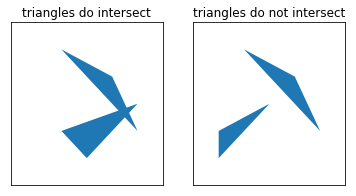

In [170]:
demo_triangle_intersection()

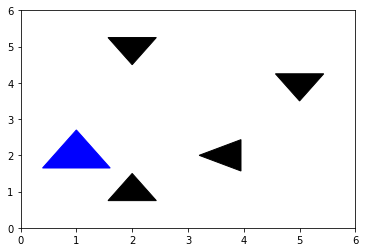

step 5/50
step 10/50
step 15/50
step 20/50
step 25/50
step 30/50
step 35/50
step 40/50
step 45/50
step 50/50


In [171]:
piano = create_triangle(xy=(1, 2), theta=pi/2, r=0.7)
obstacles = make_obstacles()

patches = [piano] + obstacles
ax = plot_world(patches)

verts_fn = lambda patch: get_verts(ax, patch)
cspace = compute_configuration_space(piano, obstacles, verts_fn)

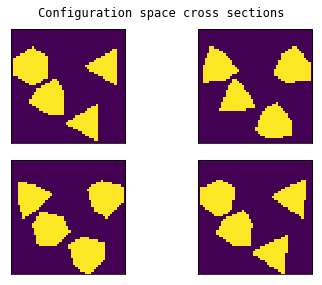

In [172]:
plot_cspace_cross_sections(cspace)

In [175]:
d = Dijkstra(cspace, start=(1, 1, 1), dest=(3, 3, 1))
route = d.dijsktra()
route

[(1, 1, 1), (1, 2, 1), (1, 3, 1), (2, 3, 1), (3, 3, 1)]

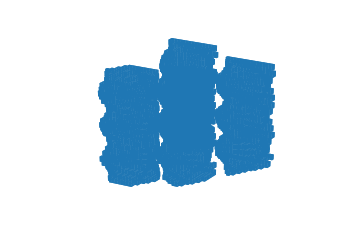

In [188]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.voxels(cspace)

for axis in (ax.w_xaxis, ax.w_yaxis, ax.w_zaxis):
    axis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    axis.line.set_color((1.0, 1.0, 1.0, 0.0))

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

plt.show()

def rotate(angle, ax):
    ax.view_init(azim=angle)
    
rot_animation = FuncAnimation(fig, rotate, fargs=(ax,), frames=np.arange(0, 360, 5), interval=100)
rot_animation.save('cspace.gif', dpi=80, writer='imagemagick')

In [189]:
def main():
    pass

In [190]:
if __name__ == '__main__':
    main()